In [1]:
import os
from datetime import datetime as dt
from glob import glob

# import calibrator
import cv2
import numpy as np
import tensorrt as trt
import torch
import torch.nn.functional as F
from cuda import cudart
from torch.autograd import Variable
import common
from tqdm import tqdm

In [2]:
from model import Net
from data import MyData

## 1. 训练模型并导出 ONNX

In [3]:
# 相关参数
BATCH_SIZE = 128
DATA_PATH = "../data/MNIST/"
calibrationDataPath = DATA_PATH + "test/"
nCalibration = 1
cacheFile = "./int8.cache"

nHeight = 28
nWidth = 28
onnxFile = "./model.onnx"
trtFile = "./model.engine"

In [4]:
model = Net().cuda()
ceLoss = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)

trainDataset = MyData(datapath = DATA_PATH, isTrain = True)
testDataset = MyData(datapath = DATA_PATH, isTrain = False)
trainLoader = torch.utils.data.DataLoader(dataset=trainDataset, batch_size=BATCH_SIZE, shuffle=True)
testLoader = torch.utils.data.DataLoader(dataset=testDataset, batch_size=BATCH_SIZE, shuffle=False)

In [5]:
def train(model, trainLoader, testLoader, opt, ceLoss, epoch):
    for epoch in tqdm(range(epoch)):
        for xTrain, yTrain in trainLoader:
            xTrain = Variable(xTrain).cuda()
            yTrain = Variable(yTrain).cuda()
            opt.zero_grad()
            y_, z = model(xTrain)
            loss = ceLoss(y_, yTrain)
            loss.backward()
            opt.step()

        with torch.no_grad():
            acc = 0
            n = 0
            for xTest, yTest in testLoader:
                xTest = Variable(xTest).cuda()
                yTest = Variable(yTest).cuda()
                y_, z = model(xTest)
                acc += torch.sum(z == torch.matmul(yTest, torch.Tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).to("cuda:0"))).cpu().numpy()
                n += xTest.shape[0]
            # print("%s, epoch %2d, loss = %f, test acc = %f" % (dt.now(), epoch + 1, loss.data, acc / n))

    print("Succeeded building model in pyTorch!")
    print("test acc = %f" % (acc / n))

In [6]:
# train(model, trainLoader, testLoader, opt, ceLoss, 25)

In [7]:
# torch.onnx.export(model, torch.randn(1, 1, nHeight, nWidth, device="cuda"), onnxFile, input_names=["x"], output_names=["y", "z"], do_constant_folding=True, verbose=True, keep_initializers_as_inputs=True, opset_version=12, dynamic_axes={"x": {0: "nBatchSize"}, "z": {0: "nBatchSize"}})
# print("Succeeded converting model into ONNX!")

# 2. 定义 Calibrator

In [8]:
class MyCalibrator(trt.IInt8EntropyCalibrator2):

    def __init__(self, calibrationDataPath, nCalibration, inputShape, cacheFile):
        trt.IInt8EntropyCalibrator2.__init__(self)
        self.imageList = glob(calibrationDataPath + "*.jpg")[:100]
        self.nCalibration = nCalibration
        self.shape = inputShape  # (N,C,H,W)
        self.buffeSize = trt.volume(inputShape) * trt.float32.itemsize
        self.cacheFile = cacheFile
        _, self.dIn = cudart.cudaMalloc(self.buffeSize)
        self.oneBatch = self.batchGenerator()

        print(int(self.dIn))

    def __del__(self):
        cudart.cudaFree(self.dIn)

    def batchGenerator(self):
        for i in range(self.nCalibration):
            print("> calibration %d" % i)
            subImageList = np.random.choice(self.imageList, self.shape[0], replace=False)
            yield np.ascontiguousarray(self.loadImageList(subImageList))

    def loadImageList(self, imageList):
        res = np.empty(self.shape, dtype=np.float32)
        for i in range(self.shape[0]):
            res[i, 0] = cv2.imread(imageList[i], cv2.IMREAD_GRAYSCALE).astype(np.float32)
        return res

    def get_batch_size(self):  # necessary API
        return self.shape[0]

    def get_batch(self, nameList=None, inputNodeName=None):  # necessary API
        try:
            data = next(self.oneBatch)
            cudart.cudaMemcpy(self.dIn, data.ctypes.data, self.buffeSize, cudart.cudaMemcpyKind.cudaMemcpyHostToDevice)
            return [int(self.dIn)]
        except StopIteration:
            return None

    def read_calibration_cache(self):  # necessary API
        if os.path.exists(self.cacheFile):
            print("Succeed finding cahce file: %s" % (self.cacheFile))
            with open(self.cacheFile, "rb") as f:
                cache = f.read()
                return cache
        else:
            print("Failed finding int8 cache!")
            return

    def write_calibration_cache(self, cache):  # necessary API
        with open(self.cacheFile, "wb") as f:
            f.write(cache)
        print("Succeed saving int8 cache!")
        return

# 3. 创建 Engine

In [9]:
logger = trt.Logger(trt.Logger.ERROR)

builder = trt.Builder(logger)

config = builder.create_builder_config()      
config.set_flag(trt.BuilderFlag.INT8)
config.int8_calibrator = MyCalibrator(calibrationDataPath, nCalibration, (1, 1, nHeight, nWidth), cacheFile)

network = builder.create_network(1 << int(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH))

parser = trt.OnnxParser(network, logger)
with open(onnxFile, "rb") as model:
    if not parser.parse(model.read()):
        print("Failed parsing .onnx file!")
        for error in range(parser.num_errors):
            print(parser.get_error(error))
        exit()
    print("Succeeded parsing .onnx file!")
    
profile = builder.create_optimization_profile()
inputTensor = network.get_input(0)
profile.set_shape(inputTensor.name, [1, 1, nHeight, nWidth], [4, 1, nHeight, nWidth], [8, 1, nHeight, nWidth])
config.add_optimization_profile(profile) 
network.unmark_output(network.get_output(0))  

140144682205184
Succeeded parsing .onnx file!


In [10]:
engineString = builder.build_serialized_network(network, config)
if engineString == None:
    print("Failed building engine!")
    exit()
print("Succeeded building engine!")
with open(trtFile, "wb") as f:
    f.write(engineString)

Succeed finding cahce file: ./int8.cache
Succeed finding cahce file: ./int8.cache
Succeeded building engine!


In [11]:
engine = trt.Runtime(logger).deserialize_cuda_engine(engineString)

if engine == None:
    print("Failed building engine!")
print("Succeeded building engine!")

Succeeded building engine!


In [12]:
for idx in range(engine.num_bindings):
    
    name = engine.get_tensor_name (idx)
    is_input = engine.get_tensor_mode (name)
    op_type = engine.get_tensor_dtype(name)
    shape = engine.get_tensor_shape(name)

    print('input id:',idx,'   is input: ', is_input,'  binding name:', name, '  shape:', shape, 'type: ', op_type)

input id: 0    is input:  TensorIOMode.INPUT   binding name: x   shape: (-1, 1, 28, 28) type:  DataType.FLOAT
input id: 1    is input:  TensorIOMode.OUTPUT   binding name: z   shape: (-1,) type:  DataType.INT32


# 测试

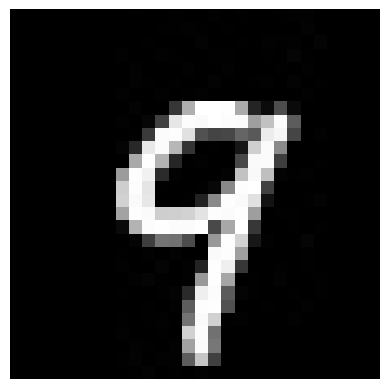

In [13]:
import matplotlib.pyplot as plt

img_1 = testDataset[12][0] # torch.Size([1, 28, 28])
# 将 Torch 张量转换为 NumPy 数组
img_np = img_1.squeeze().numpy()

# 使用 Matplotlib 显示图像
plt.imshow(img_np, cmap='gray')
plt.axis('off')  # 不显示坐标轴
plt.show()

In [14]:
with engine.create_execution_context() as context:
    inputs, outputs, bindings, stream = common.allocate_buffers(engine, 0)
    context.set_optimization_profile_async(0, stream)
    
    data = img_1.unsqueeze(0).numpy()
    context.set_input_shape('x', data.shape)
    
    inputs[0].host = data
    # load_test_case(inputs[0].host, data)
    
    trt_outputs = common.do_inference_v2(context, bindings=bindings, inputs=inputs, outputs=outputs, stream=stream)
    # result = trt_outputs
    print("result", trt_outputs[0][0])
    del context

result 9


In [15]:
common.free_buffers(inputs, outputs, stream)

# 测试 - 精度

In [16]:
BATCH_SIZE = 8
DATA_PATH = "../data/MNIST/"

testDataset = MyData(datapath = DATA_PATH, isTrain = False)
testLoader = torch.utils.data.DataLoader(dataset=testDataset, batch_size=BATCH_SIZE, shuffle=False)

In [17]:
inputs, outputs, bindings, stream = common.allocate_buffers(engine, 0)

In [18]:
def test_tensorrt_acc(engine, test_loader):
    correct = 0
    with engine.create_execution_context() as context:
        context.set_optimization_profile_async(0, stream)
        for _, (image, label) in enumerate(test_loader):
            image = image.numpy()
            context.set_input_shape('x', image.shape)
            inputs[0].host = image
            # load_test_case(inputs[0].host, image)
            preds = common.do_inference_v2(context, bindings=bindings, inputs=inputs, outputs=outputs, stream=stream)[0]
            label = np.argmax(label.numpy(), axis=-1)
            count = 0
            for i in range(len(label)):
                if label[i] == preds[i]:
                    count += 1
            correct += count
        del context
    print('\nTest set: Accuracy: {:.3f}%\n'.format(100. * correct / len(test_loader.dataset)))

In [19]:
test_tensorrt_acc(engine, testLoader)


Test set: Accuracy: 91.100%



In [20]:
common.free_buffers(inputs, outputs, stream)

# 测试 - 速度

In [21]:
inputs, outputs, bindings, stream = common.allocate_buffers(engine, 0)

In [22]:
import time
def test_tensorrt_for_test(engine):
    i = 0
    total_time_span = 0
    with engine.create_execution_context() as context:
        context.set_optimization_profile_async(0, stream)
        # warm up
        input_shape = engine.get_tensor_shape('x')
        input_shape[0] = engine.get_tensor_profile_shape('x', 0)[-1][0]
        print('input_shape', input_shape)
        
        data = np.random.rand(*input_shape).astype(np.float32)
        
        context.set_input_shape('x', data.shape)
        inputs[0].host = data
        # load_test_case(inputs[0].host, data)
        for i in range(10):
            pred = common.do_inference_v2(context, bindings=bindings, inputs=inputs, outputs=outputs, stream=stream)
        for i in range(1000):
#             data = np.random.rand(*input_shape).astype(np.float32)
#             load_test_case(inputs[0].host, data)
            # =======================================
            # The common do_inference function will return a list of outputs - we only have one in this case.

            start_time = time.time()
            pred = common.do_inference_v2(context, bindings=bindings, inputs=inputs, outputs=outputs, stream=stream)
            time_span = time.time() - start_time

            total_time_span += time_span
        total_time_span /= 1000.0
        print('total_time_span', total_time_span)
        # del context if not reuse
        del context

In [23]:
test_tensorrt_for_test(engine)

input_shape (8, 1, 28, 28)
total_time_span 6.975817680358886e-05


In [24]:
common.free_buffers(inputs, outputs, stream)

In [25]:
0.0001 / (0.0001 - 7.948040962219238e-05)

4.873391630085957